<a href="https://colab.research.google.com/github/Tamoghna-Sarkar/Neural-Network-model-for-Danger-predictions-Pytorch/blob/master/IIT(KGP)_SDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [0]:
df = pd.read_csv("/COPY - Copy.csv")
df.head()

,Unnamed: 0,sensor_id,location,lat,lon,timestamp,pressure,temperature,humidity,danger_preds
0,1,2266,1140,42.738,23.272,2017-07-01T00:00:07,95270.27,23.46,62.48,1
1,5,2292,1154,42.663,23.273,2017-07-01T00:00:08,94355.83,23.06,59.46,1
2,7,3096,1558,42.700,23.360,2017-07-01T00:00:10,95155.81,26.53,44.38,0
3,9,3428,1727,42.624,23.406,2017-07-01T00:00:12,94679.57,28.34,38.28,0
4,10,3472,1750,42.669,23.318,2017-07-01T00:00:13,94327.88,26.31,46.37,0


In [0]:
# dropping passed columns 
df.drop(["lat", "lon", "location", "timestamp"], axis = 1, inplace = True)

In [0]:
df.tail()

,Unnamed: 0,sensor_id,pressure,temperature,humidity,danger_preds
109994,303578,3512,95659.08,19.52,66.54,0
109995,303581,3438,95816.67,16.66,72.32,1
109996,303582,2292,95009.27,21.85,51.82,0
109997,303585,2607,95112.61,28.97,35.07,0
109998,303590,3096,95845.81,20.58,56.75,0


In [0]:

df.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [0]:
df.head()


,sensor_id,pressure,temperature,humidity,danger_preds
0,2266,95270.27,23.46,62.48,1
1,2292,94355.83,23.06,59.46,1
2,3096,95155.81,26.53,44.38,0
3,3428,94679.57,28.34,38.28,0
4,3472,94327.88,26.31,46.37,0


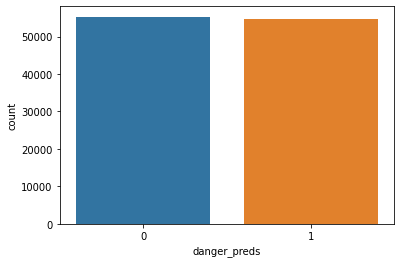

In [0]:
sns.countplot(x = 'danger_preds', data=df)
#class imbalance with bar plot

In [0]:
X = df.iloc[:, 1:4]
y = df.iloc[:, -1]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [0]:
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 0.001

In [0]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [0]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [0]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 3.
        self.layer_1 = nn.Linear(3, 16) 
        self.layer_2 = nn.Linear(16, 16)
        self.layer_out = nn.Linear(16, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(16)
        self.batchnorm2 = nn.BatchNorm1d(16)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [0]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=3, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [0]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [0]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.69573 | Acc: 49.959
Epoch 002: | Loss: 0.69372 | Acc: 49.960
Epoch 003: | Loss: 0.69358 | Acc: 49.939
Epoch 004: | Loss: 0.69337 | Acc: 50.108
Epoch 005: | Loss: 0.69329 | Acc: 50.219
Epoch 006: | Loss: 0.69333 | Acc: 49.834
Epoch 007: | Loss: 0.69322 | Acc: 50.273
Epoch 008: | Loss: 0.69323 | Acc: 49.977
Epoch 009: | Loss: 0.69323 | Acc: 50.086
Epoch 010: | Loss: 0.69322 | Acc: 49.936
Epoch 011: | Loss: 0.69322 | Acc: 50.120
Epoch 012: | Loss: 0.69316 | Acc: 50.239
Epoch 013: | Loss: 0.69312 | Acc: 50.382
Epoch 014: | Loss: 0.69319 | Acc: 50.140
Epoch 015: | Loss: 0.69322 | Acc: 49.995
Epoch 016: | Loss: 0.69320 | Acc: 50.142
Epoch 017: | Loss: 0.69321 | Acc: 49.918
Epoch 018: | Loss: 0.69318 | Acc: 50.340
Epoch 019: | Loss: 0.69320 | Acc: 50.201
Epoch 020: | Loss: 0.69320 | Acc: 49.763
Epoch 021: | Loss: 0.69322 | Acc: 50.240
Epoch 022: | Loss: 0.69320 | Acc: 50.157
Epoch 023: | Loss: 0.69322 | Acc: 50.047
Epoch 024: | Loss: 0.69320 | Acc: 50.304
Epoch 025: | Los

In [0]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [0]:
confusion_matrix(y_test, y_pred_list)

array([[18101,    83],
       [18029,    87]])

In [0]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     18184
           1       0.51      0.00      0.01     18116

    accuracy                           0.50     36300
   macro avg       0.51      0.50      0.34     36300
weighted avg       0.51      0.50      0.34     36300

